In [4]:
%matplotlib notebook

from collections import Counter
import pandas as pd
from functools import reduce
import csv

First, we'll read in the annotated data from the training set, and extract the headers

In [18]:
with open('training-1-annotated.csv', newline='') as f:
    reader = csv.reader(f)
    lines = [l for l in reader]
data = pd.DataFrame(lines[1:], columns=lines[0])

lines = lines[1:]

We'll extract the statement references and their labels, then naively break those into words using whitespace so we can look at the distribution.

In [19]:
refs_and_labels = [(l[1],l[4]) for l in lines]
words = reduce(lambda a, b: a + b[0].split(), refs_and_labels, [])


Now we've got a single list of every occurence of every word in the dataset. It'd be useful to have the labels for these two, so we'll do a similar reduction over the list, replicating the reference's label according to the number of words in the row:

In [20]:
word_categories = reduce(lambda a, b: a + len(b[0].split())*[b[1]], refs_and_labels, [])


Now we'll count the words / labels so we can draw some handy histograms of the distribution of the words, and the per-word labels...

<IPython.core.display.Javascript object>


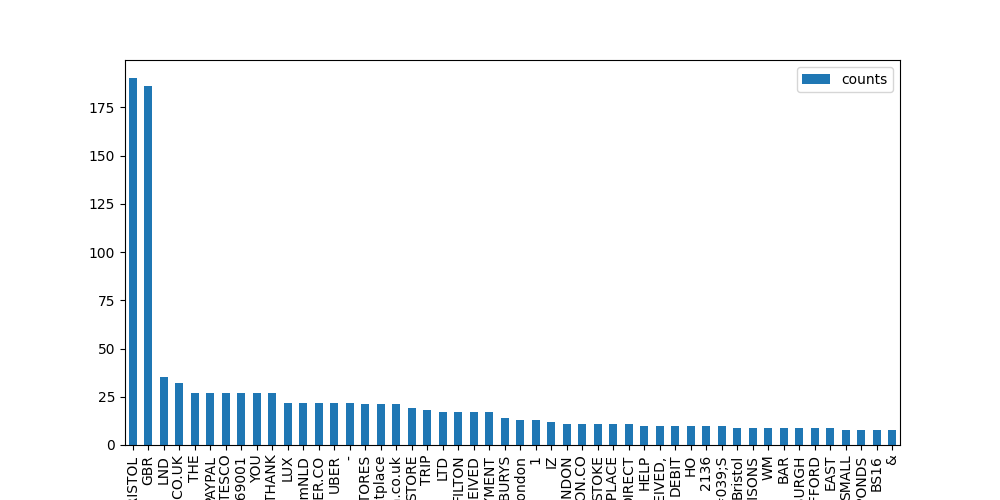

In [25]:
def plot_word_histogram(words, lim=None):
    word_counts = Counter(words)
    df_counts = pd.DataFrame.from_dict(word_counts, orient="index", columns = ["counts"])
    df_counts = df_counts.sort_values('counts',ascending=False)
    to_plot = df_counts if lim is None else df_counts[:50]
    to_plot.plot(kind='bar',figsize=(10,5))

# Only plot the top 50 for the sake of readibility
plot_word_histogram(words, 50)


The dataset is pretty biased towards Bristol and GBR, but I guess that's not surprising as it appears in most of the transactions. Might be a pain later though...

Let's look at the distribution of per-word categories:

<IPython.core.display.Javascript object>


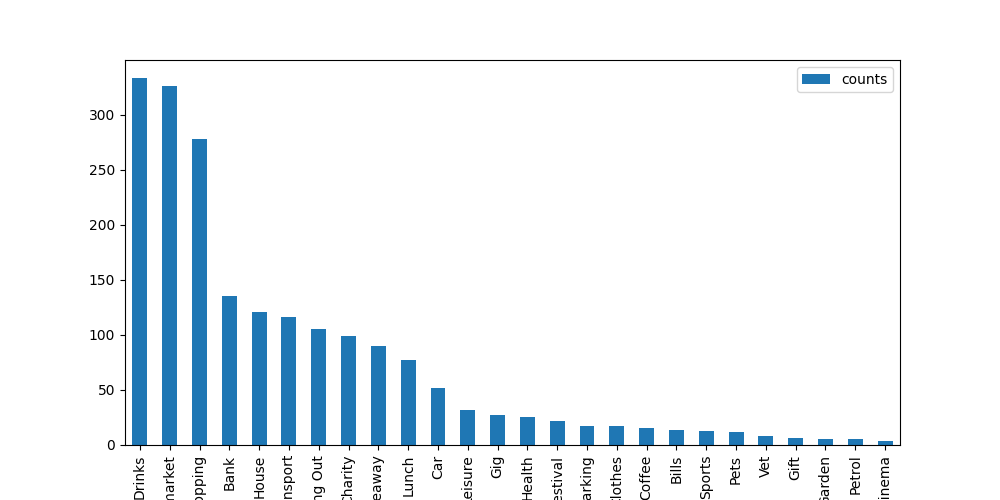

In [28]:
plot_word_histogram(word_categories)

Either I drink too much, or pubs tend to have more words per reference. Let's go with the latter...

Ok so that's interesting, but we can't do much with the raw words. [Facebook's FastText](https://fasttext.cc) algorithm should give us some quick and easy pre-trained embeddings so we can start doing something more interesting. The following is ripped almost verbatim from [their website](https://fasttext.cc/docs/en/english-vectors.html).

Loading the full vocab takes a long time, and it's ordered by most common words first. We'll see if we can get away with a reduce vocab first...

In [61]:
import io
from tqdm.notebook import tqdm

# I've added a max-vocab size here as loading the whole 999995 entries is very slow.
# Maybe we don't need the whole vocab? (more on that later)
def load_vectors(fname, max_vocab=None):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    
    data = {}
    
    for v_count, line in enumerate(tqdm(fin, desc="Loading embeddings...")):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
        v_count += 1
        if max_vocab is not None and v_count > max_vocab:
            break
    return data

embeds = load_vectors("data/wiki-news-300d-1M.vec",10000)

Takes a while, but now we have a bunch of word embeddings so we might be able to do something useful with our data.

First, let's take a look at how many unknown tokens we have relative to others to make sure our reduced vocab hasn't broken anything.

To do this, we'll `import fasttext` and use the `tokenize()` method to convert our input into [compatible tokens](https://fasttext.cc/docs/en/python-module.html#important-preprocessing-data--encoding-conventions).

Then we'll run through all the descriptions and replace tokens that don't appear in the vocab, with an `<unk>` symbol to indicate they're unkown.

In [36]:
import fasttext

def tokenize_data(annotated_names, embeddings):
    tokenised_data = [(fasttext.tokenize(x[0].lower()), x[1]) for x in annotated_names]
    tokenised_with_unknowns = [([x if x in embeddings else '<unk>' for x in d[0]], d[1]) for d in tokenised_data]
    return tokenised_with_unknowns

tokenized_refs_and_labels = tokenize_data(refs_and_labels, embeds)
tokenized_refs_and_labels

[(['02', '<unk>', '<unk>', '<unk>', '<unk>'], 'Drinks'),
 (['28', '<unk>', 'place', '<unk>', '<unk>', '<unk>'], 'Drinks'),
 (['<unk>', '<unk>', 'from', '<unk>', '<unk>'], 'Eating Out'),
 (['<unk>', '<unk>', '<unk>'], 'Drinks')]

Oof, doesn't look pretty. Lets get the full list of words out and checkout the token distribution...

<IPython.core.display.Javascript object>


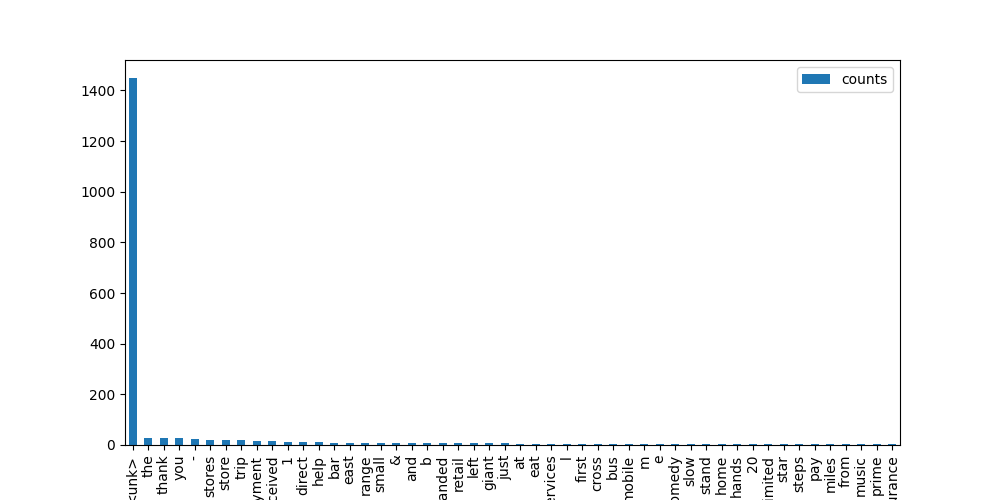

In [30]:
stacked_tokenized_refs = reduce(lambda x, y: x + y[0], tokenized_refs_and_labels, [])
plot_word_histogram(stacked_tokenized_refs, 50)

Hmm, not great, let's try some bigger vocabs...

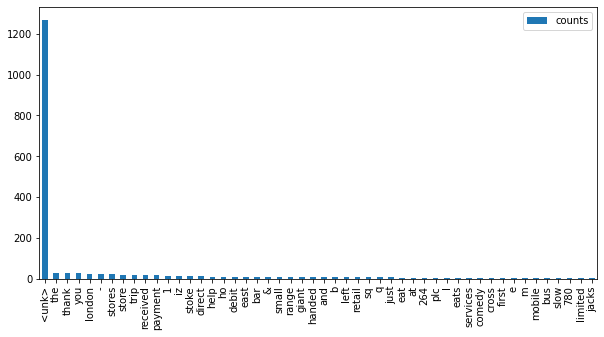

In [57]:
embeds = load_vectors("data/wiki-news-300d-1M.vec",50000)
tokenized_refs_and_labels = tokenize_data(refs_and_labels, embeds)
stacked_tokenized_refs = reduce(lambda x, y: x + y[0], tokenized_refs_and_labels, [])
plot_word_histogram(stacked_tokenized_refs, 50)

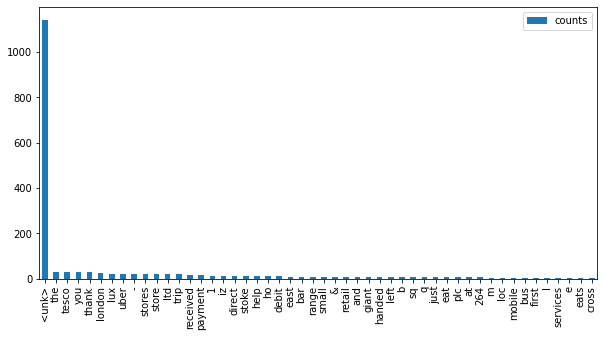

In [58]:
embeds = load_vectors("data/wiki-news-300d-1M.vec",100000)
tokenized_refs_and_labels = tokenize_data(refs_and_labels, embeds)
stacked_tokenized_refs = reduce(lambda x, y: x + y[0], tokenized_refs_and_labels, [])
plot_word_histogram(stacked_tokenized_refs, 50)

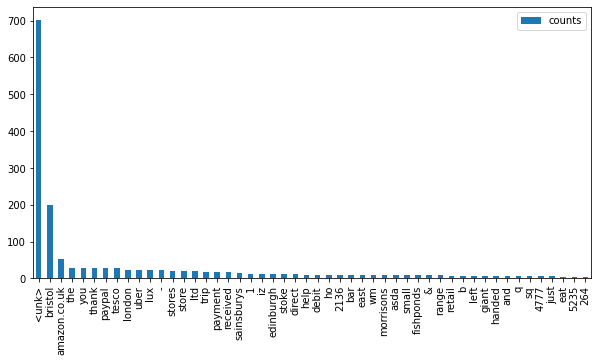

In [59]:
embeds = load_vectors("data/wiki-news-300d-1M.vec",500000)
tokenized_refs_and_labels = tokenize_data(refs_and_labels, embeds)
stacked_tokenized_refs = reduce(lambda x, y: x + y[0], tokenized_refs_and_labels, [])
plot_word_histogram(stacked_tokenized_refs, 50)

In [ ]:
embeds = load_vectors("data/wiki-news-300d-1M.vec")
tokenized_refs_and_labels = tokenize_data(refs_and_labels, embeds)
stacked_tokenized_refs = reduce(lambda x, y: x + y[0], tokenized_refs_and_labels, [])
plot_word_histogram(stacked_tokenized_refs, 50)